In [1]:
import pprint
import numpy as np
from Crypto.Random.random import getrandbits

# Prerequisites
-  Block ciphers design

In [2]:
def get_bit(x, i, n):
    '''
    n = 5
    x = 0 1 0 1 0 
    i = 0 1 2 3 4
    '''
    return (x >> (n - 1 - i)) & 1

def inverse_sbox(S):
    """
    Input:
    S: {list} -- sbox
    Return
    {list} -- the inverse of the sbox
    """
    S_ = [-1] * len(S)
    for i, entry in enumerate(S):
        S_[entry] = i
    return S_
    

# Theory

For this page we denote the following

- $M$ is a message
- $C$ is a ciphertext
- $K$ is a key
- greek letters for masks

Sometimes we will denote
- $X$ - Sbox input
- $Y$ - Sbox output

*Idea*
- We have a message $M$. We change some bits in it. We try to predict the change in ciphertext
- The idea is that for each possible input difference of 2 inputs $(M, M')$the output difference of $(C, C')$ should be equally likely. Differential cryptanalysis exploits the fact that it isn't

Attack goals
- Key recovery
- Collision

## Differences

**Difference - Definition**
> Given the bit strings $X$ and $X'$ the difference between them will be denoted with $\Delta X = X \oplus X'$. 
- We might denote the  input difference with $\Delta in$ and the output with $\Delta out$

We will want to look at the relation between some $\Delta in$ and some $\Delta out$. Therefore we want to track the differences.  

Therefore differential cryptanalysis is a *chosen plaintext attack* because we will choose some input $X$ and some difference $\Delta X$ and compute our second input $X' = X \oplus \Delta X$

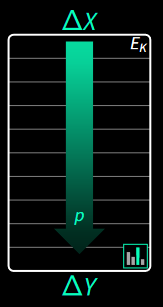

Now let's look at some possible cases

**An Sbox $S \Rightarrow Y = S[X]$**

Let $X, X', \Delta X$ be 2 inputs and the difference between them. Then $$\Delta Y = Y \oplus Y' = S[X] \oplus S[X'] = S[X] \oplus S[X \oplus \Delta X]$$

**The difference distribution table - Definition**
> For all input differences $\Delta X$ and all output differences $\Delta Y$ we can make a table which counts the frequency of an output difference for all inputs pairs $(X, X' = X \oplus \Delta X)$
> - An entry $(\Delta X, \Delta Y)$ counts the number of input pairs $(X, X' = X \oplus \Delta X)$ that give $\Delta Y$
> - The entry is also called a **characteristic** across an sbox $S$

**Remark**
- Knowing the differences $(\Delta X, \Delta Y)$ tells us something about the value
    - Not all values can produce these differences
    - Only a subset of *solutions*: $\{X \ : \ S(X \oplus \Delta X) \oplus S(X) = \delta Y\}$
    
    

**The propagation ratio- Definition**  
If we divide by the possible outputs we can represent the **propagation ratio** (probability):
$$Pr[\Delta out = \Delta Y | \Delta in = \Delta X] = \dfrac {DDT(\Delta X, \Delta Y)} {2^l}$$
- where $l$ = output size

**Properties**
- Sum of elements in a row is the number of possible inputs
- Sum of elements in a column is the number of possible outputs
- All elements are even
- $\Delta X = 0 \Rightarrow \Delta Y = 0$ for one-to-one S-boxes

**The ideal S-box** => all elements in DDT = 1

In [3]:
S = [0x2, 0x0, 0x4, 0x3, 0x9, 0x5, 0x6, 0x7, 0x1, 0xd, 0xe, 0xf, 0xa, 0x8, 0xc, 0xb]

In [4]:
def difference_distribution_table(S, l = 4):
    res = [[0] * (1<<l) for _ in range(1<<l)]
    for delta_x in range(1<<l):
        for x in range(1<<l):
            x_ = x ^ delta_x
            delta_y = S[x] ^ S[x_]
            res[delta_x][delta_y]+=1
    return res
        

In [5]:
ddt = difference_distribution_table(S)
print(np.matrix(ddt))

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  4  0  0  0  0  4  0  0  0  0  4  0  0  0]
 [ 0  0  4  4  0  0  4  0  0  0  0  0  0  0  0  4]
 [ 0  4  0  4  4  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  4  0  4  4  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  4  0  4  0  4  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  4  4  0  0  0  0  0  4  0  0]
 [ 0  4  0  0  0  4  4  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  4  0  4  4  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  4  0  4  0  4]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  4  0  4  4]
 [ 0  0  4  0  0  0  0  0  0  4  0  0  0  4  4  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  4  4  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  4  0  0  4  4  0  0  4  0]
 [ 0  0  0  0  0  0  4  0  0  4  0  4  4  0  0  0]]


In [6]:
# An interesting value  is ddt[c][8] = 16
print(ddt[0xc][8])

# All diff = 8
print(all([S[x] ^ S[x ^ 0xc] == 8 for x in range(1<<4)]))

16
True


## Adding the key

**Influence of the key**
- Adding the key does **not** change the difference
$$X \oplus K \oplus X' \oplus K = X \oplus X' = \Delta X$$

**Linear functions**  
If $f:\mathbb{F}_2 \to \mathbb{F}_2$ is an affine function $f(x) = \underbrace{l(x)}_{\text{linear part}} \oplus c$ where $c =$ constant then 
$$\Delta Y = \Delta f(\Delta X) = l(\Delta X)$$

Let's work through this example from "The block cipher companion"

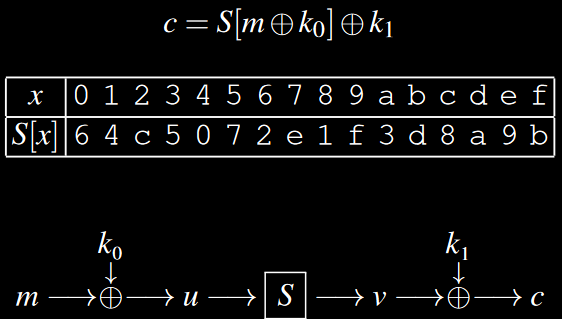

Consider a pair:
$
u_0 = m_0 \oplus k_0 \\
v_0 = S[u_0] \\
c_0 = v_0 \oplus k_1 \\
$

$
u_1 = m_1 \oplus k_0 \\
v_1 = S[u_1] \\
c_1 = v_1 \oplus k_1 \\
$
Then we have
$$u_0 \oplus u_1 =  m_0 \oplus k_0 \oplus m_1 \oplus k_0 = m_0 \oplus m_1 = \Delta m$$

And
$$u_0 \oplus u_1 = S^{-1}[v_0] \oplus S^{-1}[v_1]$$

In [7]:
def cipher_one(m, k0, k1, S):
    u = m ^ k0
    v = S[u]
    c = v ^ k1
    return c

In [8]:
S = [6, 4, 0xc, 5, 0, 7, 2, 0xe, 1, 0xf, 3, 0xd, 8, 0xa, 9, 0xb]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)
print(np.matrix(ddt))

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  2  0  2  0  0  2  0  4  0]
 [ 0  6  6  0  0  0  0  0  0  2  2  0  0  0  0  0]
 [ 0  0  0  6  0  2  0  0  2  0  0  0  4  0  2  0]
 [ 0  0  0  2  0  2  4  0  0  2  2  2  0  0  2  0]
 [ 0  2  2  0  4  0  0  4  2  0  0  2  0  0  0  0]
 [ 0  0  2  0  4  0  0  2  2  0  2  2  2  0  0  0]
 [ 0  0  0  0  0  4  4  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  2  4  0  0  4  0  2  0  2]
 [ 0  2  0  0  0  2  2  2  0  4  2  0  0  0  0  2]
 [ 0  0  0  0  2  2  0  0  0  4  4  0  2  2  0  0]
 [ 0  0  0  2  2  0  2  2  2  0  0  4  0  0  2  0]
 [ 0  4  0  2  0  2  0  0  2  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  2  2  0  0  0  0  6  2  0  4]
 [ 0  2  0  4  2  0  0  0  0  0  2  0  0  0  0  6]
 [ 0  0  0  0  2  0  2  0  0  0  0  0  0 10  0  2]]


In [9]:
k0 = getrandbits(4)
k1 = getrandbits(4)

# Let's spawn some messages and see if the characteristic holds
N = 10000
t = 0
delta_in = 0xf # input difference
delta_out = 0xd # output difference

for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_one(m, k0, k1, S)
    c_ = cipher_one(m_, k0, k1, S)
    if c ^ c_ == delta_out:
        t+=1

print(t / N, 10/16)
    

0.6268 0.625


## Adding more Sboxes

The probabilities multiply over the Sboxes. You can think of it as a Markov chain

Let $\Delta c_i$ be differential characteristic on the round $i$ where $\Delta c_0 = \Delta in$. Let $\Delta Y_i$ be a specific value of $\Delta c_i$. Then the probability is:
$$ Pr[\Delta c_i = \Delta Y_i, ..., \Delta c_1 = \Delta Y_1 \ |\  \Delta c_0 = \Delta in]$$

**Markov chain property** - https://en.wikipedia.org/wiki/Markov_chain
$$P(X_n=i_n \ ∣\ X_{n−1} =i_{n−1})=P(X_n=i_n \ ∣ \ X_0=i_0,X_1=i_1,…,X_{n−1}=i_{n−1})$$ where $X_i$ are random variables and $i_i$ are values

Therefore the probability of a chain to happen is the product of the probabilities of all the one round characteristics involved
$$ Pr[\Delta c_i = \Delta Y_i, ..., \Delta c_1 = \Delta Y_1 \ |\  \Delta c_0 = \Delta in] = \underbrace{\prod_{i=1}^{s}}_{\text{for each sbox}} \underbrace{Pr[\Delta c_1 = \Delta Y_i \ | \ \Delta c_0 = \Delta in]}_{\text{Probability of $\Delta Y$ to happen}}$$

**Note**
- In a cipher with many rounds there might be multiple ways to get from a configuration to another one (many paths). We must take all into account when computing the probability

Continuing with an example from "The block cipher companion"
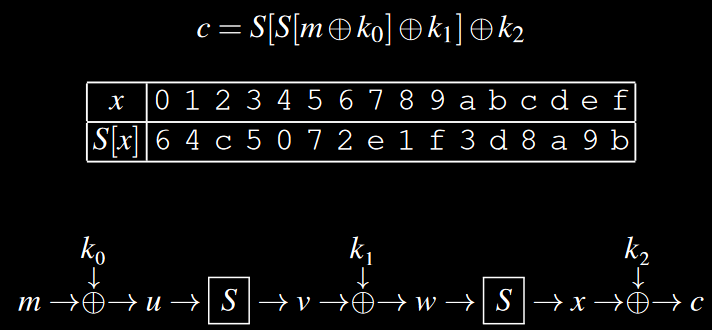

In [10]:
def cipher_two(m, k0, k1, k2, S):
    c = S[S[m ^ k0] ^ k1] ^ k2
    return c

In [11]:
S = [6, 4, 0xc, 5, 0, 7, 2, 0xe, 1, 0xf, 3, 0xd, 8, 0xa, 9, 0xb]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)

In [12]:
# Looking at our ddt table let's take the following path:
alpha0 = 0xf
alpha1 = 0xd
alpha2 = 0xc

ddt2 = np.matrix(ddt) @ np.matrix(ddt) 
p = ddt2[alpha0, alpha2] / 16**2
print(p)


0.25


In [15]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
# Let's spawn some messages and see if the characteristic holds
N = 50000
t = 0
delta_in = alpha0 # input difference
delta_out = alpha2 # output difference

for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_two(m, k0, k1, k2, S)
    c_ = cipher_two(m_, k0, k1, k2, S)
    if c ^ c_ == delta_out:
        t+=1

print(t / N, p)
    

0.25104 0.25


## Recovering the key

Recovering the key is a guessing process

1. Find a good characteristic with a probability $p \gg \dfrac 1 {2^{\text{block size}}}$
2. Query around $\dfrac 1 p$ chosen pairs
3. Decrypt 1 round with every key
4. Set a counter for each key. If we get $\Delta out$ then increment the counter


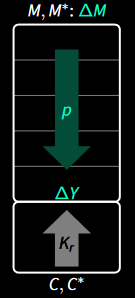

Let's break cipher two

In [16]:
S = [6, 4, 0xc, 5, 0, 7, 2, 0xe, 1, 0xf, 3, 0xd, 8, 0xa, 9, 0xb]
S_ = inverse_sbox(S)

delta_in = 0xf
delta_out = 0xd

In [17]:
def diff_attack(M_list, C_list, delta_out, S_, key_bits = 4):
    ts = [0] * (1<<key_bits)
    for k in range(1<<key_bits):
        for (m, m_), (c, c_) in zip(M_list, C_list):
            if S_[c ^ k] ^ S_[c_ ^ k] == delta_out:
                ts[k]+=1
    return ts
        

In [18]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)

# Generate message pairs
M_list = [] # List of tuples
C_list = [] # list of tuples

t = 0
N = 100000
for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_two(m, k0, k1, k2, S)
    c_ = cipher_two(m_, k0, k1, k2, S)
    
    M_list.append((m, m_))
    C_list.append((c, c_))

In [19]:
ts = diff_attack(M_list, C_list, 0xd, S_)
print(k2, np.argmax(ts))


10 10


Let's look at the next example:


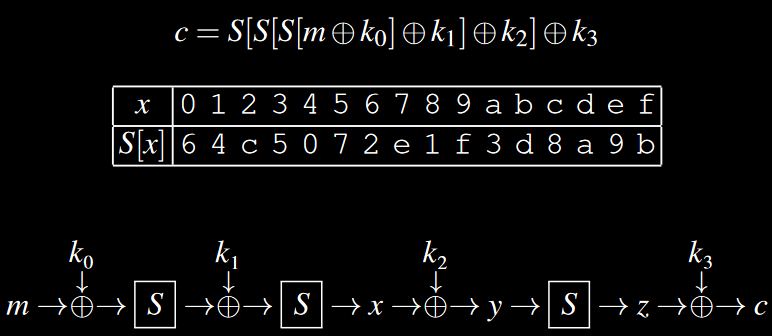

In [38]:
def cipher_three(m, k0, k1, k2, k3, S):
    c = S[S[S[m ^ k0] ^ k1] ^ k2] ^ k3
    return c

In [39]:
S = [6, 4, 0xc, 5, 0, 7, 2, 0xe, 1, 0xf, 3, 0xd, 8, 0xa, 9, 0xb]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)

p = np.matrix(ddt) @ np.matrix(ddt)  / 16 **2

In [55]:
p[2, 2] # seems like a good entry

0.28125

In [64]:
delta_in = 0xf
delta_out = 0xc

In [65]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
k3 = getrandbits(4)
# Generate message pairs
M_list = [] # List of tuples
C_list = [] # list of tuples

t = 0
N = 100000
for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_three(m, k0, k1, k2, k3, S)
    c_ = cipher_three(m_, k0, k1, k2, k3, S)
    
    M_list.append((m, m_))
    C_list.append((c, c_))

In [66]:
ts = diff_attack(M_list, C_list, 0xc, S_)
print(k3, np.argmax(ts))


8 8


## Defense against differential cryptanalysis

**The branch number**
> $\mathcal{B}$ is the minimum number of active S-boxes in 2 consecutive rounds

- We want a bigger number $\mathcal{B} = 1 + \text{num of sboxes per round}$
- The more branches we have the lower the probability of a differential to propagate

# Resources

- Block cipher companion
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf
- https://www.youtube.com/watch?v=ONhPfIABxFs&t=1s
- https://www.youtube.com/watch?v=Epb5h13S6-Q - FEAL